In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import FreqDist
from nltk.tokenize import word_tokenize

In [25]:
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows', None)

# Import Data

In [26]:
# items_df = pd.read_csv('csv_files/items_df_final.csv',index_col=0).reset_index(drop=True)
items_df = pd.read_csv('csv_files/cleaned_items_df.csv',index_col=0).reset_index(drop=True)
reviews_df = pd.read_csv('csv_files/cleaned_reviews_df.csv',index_col=0).reset_index(drop=True).rename({'rating':'review_rating'},axis=1)

In [27]:
final_df = pd.merge(left=items_df, right=reviews_df, left_on='asin_id', right_on='asin_id')
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0


In [28]:
final_df.shape

(5490, 9)

# Count of each User Rating

In [29]:
reviews_df['user_rating'].value_counts()

5.0    3542
4.0     707
1.0     567
3.0     444
2.0     279
Name: user_rating, dtype: int64

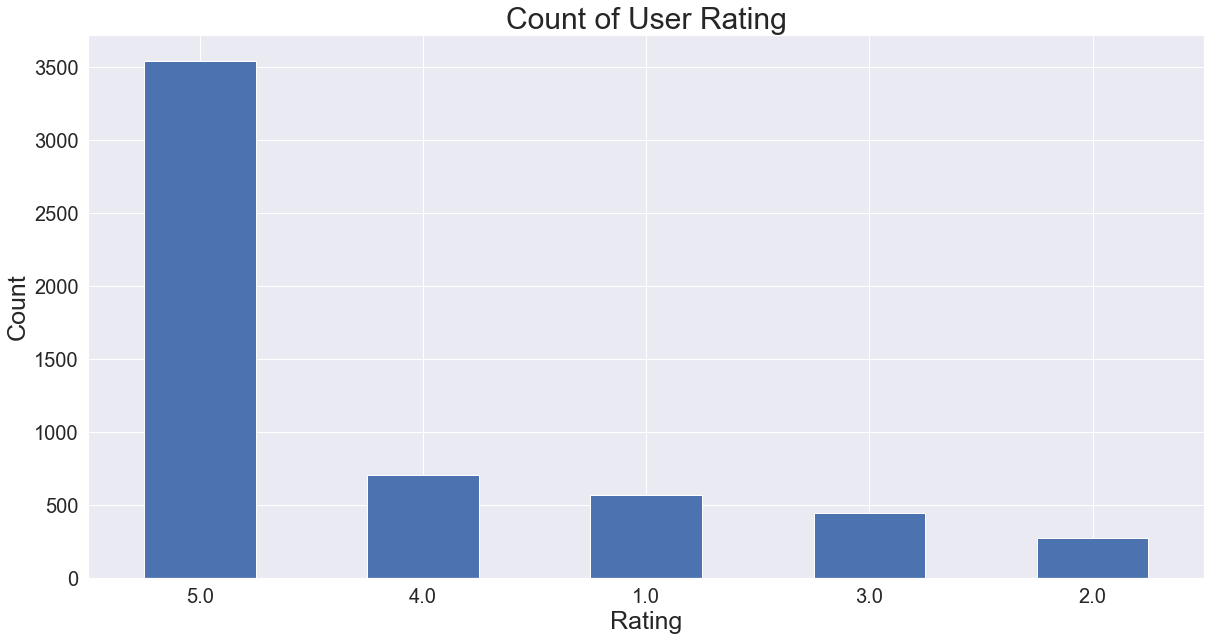

In [30]:
plt.figure(figsize=(20,10))
reviews_df['user_rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=30)
plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20);

It appears we have a class imbalance problem where the number of 5.0 reviews are much greater than the other reviews. This will cause difficulties to the machine learning algorithms so we will need to deal with it later.

# Lowest and Highest Price Item

In [31]:
items_df[items_df['price'] != 0]['price'].describe()

count    214.000000
mean      32.796168
std       46.321164
min        1.990000
25%       18.880000
50%       24.990000
75%       36.165000
max      648.980000
Name: price, dtype: float64

In [32]:
items_df[(items_df['price'] == 3.99) | (items_df['price'] == 169.99)]

,asin_id,name,price,avg_rating,no_of_ratings
139,B079XXJVQW,Game Night,3.99,4.5,2018


Based on all the board games collected, the highest priced board game is red wii mini console bundle @ 169.99 and lowest priced board game is gamemaster @ 3.99

# Number of Reviews by Board Game

In [33]:
items_df['no_of_ratings'].describe()

count      228.000000
mean      2172.618421
std       4216.751580
min          1.000000
25%        132.000000
50%        655.500000
75%       2416.250000
max      35987.000000
Name: no_of_ratings, dtype: float64

Item with the highest number of rating is 1 and highest number of rating is 35208. The mean is 2808 while the median is 1546 which tells us there are a lot more board games with a lot of ratings than of boards games with lower ratings.

# Top 10 Highest Reviewed Board Games

In [34]:
items_df.sort_values(by=['no_of_ratings'],ascending=False).head(10)

,asin_id,name,price,avg_rating,no_of_ratings
38,B010TQY7A8,Exploding Kittens Card Game - Family-Friendly ...,19.99,4.7,35987
41,B00ABA0ZOA,Jenga Classic Game,0.00,4.8,30394
46,B00D8STBHY,Hasbro Connect 4 Game,9.99,4.8,21600
153,B01MRG7T0D,What Do You Meme? Party Game,29.99,4.7,19090
32,B07P6MZPK3,Mattel Games UNO,9.99,4.9,13133
165,B014Q1XX9S,Czech Games Codenames,14.14,4.8,11934
7,B00000IVAK,SEQUENCE- Original SEQUENCE Game with Folding ...,15.17,4.8,11880
25,B00U26V4VQ,"Catan The Board Game, Multicolor",39.50,4.8,11069
13,B01MU9K3XU,Monopoly Classic Game,19.99,4.8,10481
93,0975277324,Ticket To Ride - Play With Alexa,48.11,4.8,9155


# 10 Least Reviewed Board Games

In [35]:
items_df.sort_values(by=['no_of_ratings'],ascending=True).head(10)

,asin_id,name,price,avg_rating,no_of_ratings
227,B083Q2FKTN,Escape Room The Game Expansion Pack – The Brea...,11.99,5.0,1
205,B082QSZ69K,Portal Games Detective: Season One,25.94,5.0,1
156,B08BHTL6SX,Wooden Large Sling Hockey Board Game 22inch Ca...,30.00,5.0,1
141,B08GYKSMX4,Tekhenu Obelisk of The Sun,53.30,5.0,1
160,B08B53WGWX,Alderac Entertainment Group (AEG) Calico,37.71,5.0,1
107,B084BJRQQB,Ravensburger The Castles of Tuscany Strategy G...,44.99,5.0,2
72,B085B23JHC,"Hedbanz Picture Guessing Board Game, for Famil...",11.99,4.6,3
140,B08H1HW596,Leder Games Fort Card Game,29.88,5.0,3
217,B08CZCLCQB,Aneco Halloween Ghost Dart Board Sticky Balls ...,14.99,4.0,3
184,B07ZP8HFNP,Joyful Mathematics MULTI Board Game,25.00,5.0,4


# Is there a correlation between price and number of ratings/avg_rating?

In [36]:
items_df[items_df['price'] != 0].corr(method ='pearson')

,price,avg_rating,no_of_ratings
price,1.000000,-0.061870,-0.091587
avg_rating,-0.061870,1.000000,0.122684
no_of_ratings,-0.091587,0.122684,1.000000


# Scatter Plot of Average Rating and Price

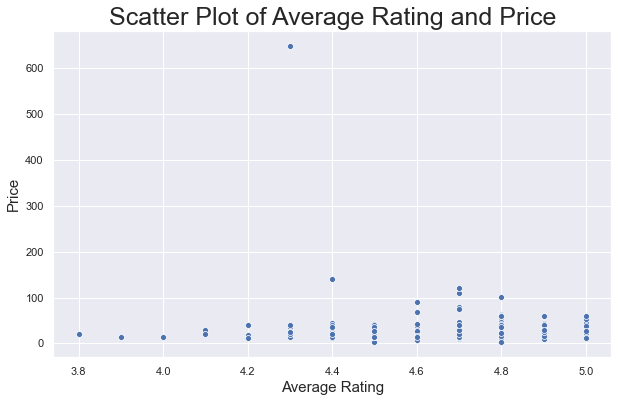

In [37]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=items_df[items_df['price'] != 0], x='avg_rating', y='price')
plt.title('Scatter Plot of Average Rating and Price',fontsize=25)
# Set x-axis label
plt.xlabel('Average Rating',fontsize=15)
# Set y-axis label
plt.ylabel('Price',fontsize=15)
sns.set(font_scale = 1)

# Natural Language Processing (NLP)

Using natural language tool kit (NLTK) which is the most popular NLP libraries in Python, we're going to analyze the natural human language for all the amazon reviews in our data.

In [38]:
# strip '/n' characters from title and description
final_df['review_title'] = final_df['review_title'].apply(lambda x:x.strip('\n'))

# was getting an error when stripping review_description due to N/A (row 56)
final_df['review_description'][final_df['review_description'].isna()]
final_df['review_description'] = final_df['review_description'].fillna('-1')
final_df['review_description'] = final_df['review_description'].apply(lambda x:x.strip('\n'))

In [39]:
def clean_text(text):
    
    cleaned_text = "".join([x for x in text if x not in string.punctuation]) # remove punctuation
    cleaned_text = cleaned_text.lower() # lowercase all characters
    cleaned_text = cleaned_text.strip() # strip whitespace
    cleaned_text = re.sub('[0-9]+', '', cleaned_text)
    
    # remove all emojis
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    cleaned_text = deEmojify(cleaned_text)
    
    tokens = cleaned_text.split(" ") # split string into list of words
    
    STOPWORDS=stopwords.words("english") # stopwords - commonly used words eg is, he, we, etc.
    cleaned_text = [token for token in tokens if token not in STOPWORDS] # filter out stopwords
    

    return ' '.join(cleaned_text)

In [40]:
# # tokenize the data by removing all emojis, punctuation, white spaces, convert to lowercase, not stopwords
# def clean_text(text):
#     ps=PorterStemmer()
    
#     text=deEmojify(text) # remove emojis
#     text_cleaned="".join([x for x in text if x not in string.punctuation]) # remove punctuation
    
#     text_cleaned=re.sub(' +', ' ', text_cleaned) # remove extra white spaces
#     text_cleaned=text_cleaned.lower() # converting to lowercase
#     tokens=text_cleaned.split(" ")
#     tokens=[token for token in tokens if token not in STOPWORDS] # Taking only those words which are not stopwords
#     text_cleaned=" ".join([ps.stem(token) for token in tokens])
    
#     return text_cleaned

In [41]:
# tokenize the data
final_df['cleaned_title']= final_df['review_title'].apply(lambda x:clean_text(x))
final_df['cleaned_reviews']= final_df['review_description'].apply(lambda x:clean_text(x))

In [42]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero stars could youre original sor...
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawns per team instead tr...
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,bought replace old sorry game falling apart w...
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warned sorry grew three tokens per player rule...
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawns cards instead d...


In [43]:
final_df.to_csv('csv_files/cleaned_items_reviews_df.csv')

## Unigram - Individual Words

### Common Words for Reviews

In [44]:
# convert dataframe series into frequency distribution
def convert_df_column_as_freq_dist(dataframe,column,no_common_words=10):

    word_dict = []

    for row in dataframe[column]:
        split_row = str(row).split()
        for word in split_row:
            word_dict.append(word)
            
    title_freqdist = FreqDist(word_dict)
    
    return title_freqdist.most_common(no_common_words)

In [45]:
most_common_words_reviews = dict(convert_df_column_as_freq_dist(final_df,'cleaned_reviews',no_common_words=20))
most_common_words_reviews

{'game': 12427,
 'play': 3897,
 'fun': 2871,
 'one': 2650,
 'board': 2395,
 'cards': 2274,
 'like': 2148,
 'games': 1990,
 'get': 1799,
 'great': 1723,
 'playing': 1704,
 'played': 1652,
 'time': 1537,
 'really': 1525,
 'would': 1492,
 'kids': 1294,
 'love': 1294,
 'family': 1260,
 'old': 1245,
 'players': 1163}

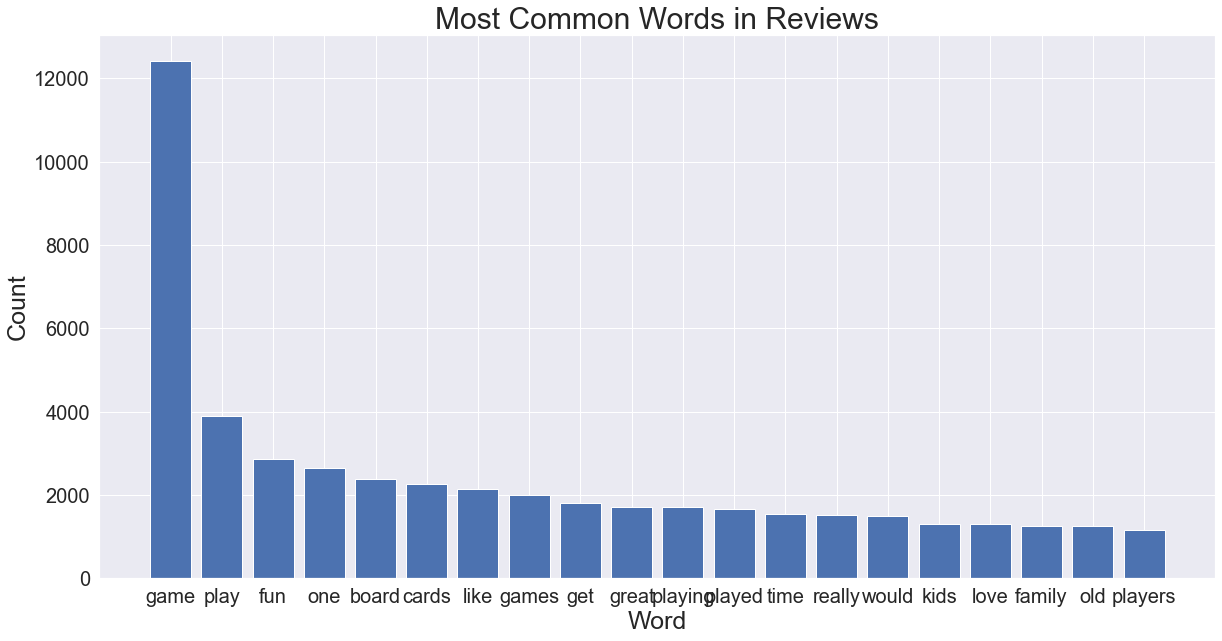

In [46]:
keys = most_common_words_reviews.keys()
values = most_common_words_reviews.values()

plt.figure(figsize=(20,10))
plt.title('Most Common Words in Reviews',fontsize=30)

plt.xlabel('Word',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)

plt.bar(keys, values);

### WordCloud for Most Common Words

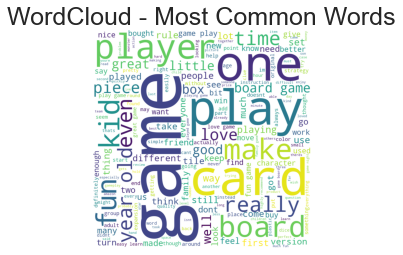

In [47]:
from wordcloud import WordCloud
wordcloud_reviews = WordCloud(height=1000, width=1000, background_color='white')
wordcloud_reviews = wordcloud_reviews.generate(' '.join(final_df['cleaned_reviews'].tolist()))
plt.imshow(wordcloud_reviews)
plt.title("WordCloud - Most Common Words", fontsize=25)
plt.axis('off')
plt.show()

### Common words for Title

In [48]:
# most_common_words_title = dict(convert_df_column_as_freq_dist(final_df,'cleaned_title',no_common_words=10))
# most_common_words_title

In [49]:
# keys = most_common_words_title.keys()
# values = most_common_words_title.values()

# plt.figure(figsize=(20,10))
# plt.title('Most Common Words (Review Title)',fontsize=30)

# plt.xlabel('Word',fontsize=25)
# plt.xticks(fontsize=20)
# plt.ylabel('Count',fontsize=25)
# plt.yticks(fontsize=20)

# plt.bar(keys, values)

In [50]:
# wordcloud_description = WordCloud(height=2000, width=2000, background_color='white')
# wordcloud_description = wordcloud_description.generate(' '.join(final_df['cleaned_reviews'].tolist()))
# plt.imshow(wordcloud_description)
# plt.title("Most common words in the title")
# plt.axis('off')
# plt.show()

# Bigrams

In [51]:
# convert dataframe column into a bag of words
def convert_df_column_as_freq_dist_bigrams(dataframe,column, reverse_order=True, no_of_bigrams=10):
    
    import itertools

    bigrams_dict = {}

    for row in dataframe[column]:
        nltk_token = nltk.word_tokenize(row)
        bigram = list(nltk.bigrams(nltk_token))
        for pair_bigram in bigram:
            if pair_bigram in bigrams_dict:
                bigrams_dict[pair_bigram] += 1
            else:
                bigrams_dict[pair_bigram] = 1 
    
    sorted_bigrams_dict = {k: v for k, v in sorted(bigrams_dict.items(), 
                                    key=lambda item: item[1],
                                    reverse=reverse_order)}
    
    return dict(itertools.islice(sorted_bigrams_dict.items(), no_of_bigrams))

In [52]:
# outputs the most common bigrams as a dictionary of frequency distribution
most_common_bigrams = convert_df_column_as_freq_dist_bigrams(final_df,'cleaned_reviews',
                                                             reverse_order=True,
                                                             no_of_bigrams=20)
most_common_bigrams

{('year', 'old'): 798,
 ('board', 'game'): 467,
 ('game', 'play'): 414,
 ('fun', 'game'): 411,
 ('board', 'games'): 353,
 ('great', 'game'): 351,
 ('love', 'game'): 322,
 ('play', 'game'): 298,
 ('easy', 'learn'): 293,
 ('playing', 'game'): 222,
 ('much', 'fun'): 209,
 ('highly', 'recommend'): 206,
 ('game', 'board'): 202,
 ('game', 'fun'): 196,
 ('family', 'game'): 196,
 ('fun', 'play'): 170,
 ('game', 'night'): 167,
 ('played', 'game'): 166,
 ('lot', 'fun'): 165,
 ('first', 'time'): 161}

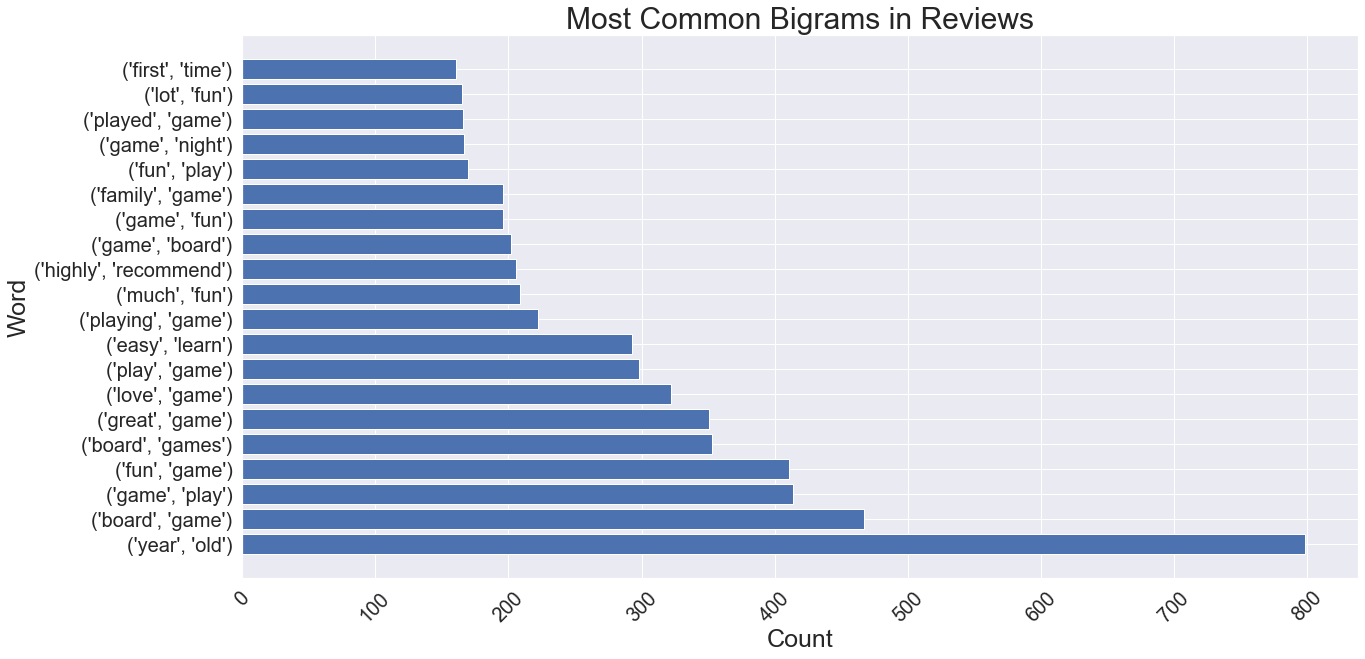

In [53]:
keys = [str(key) for key in most_common_bigrams.keys()]
values = most_common_bigrams.values()

plt.figure(figsize=(20,10))
plt.title('Most Common Bigrams in Reviews',fontsize=30)

plt.xlabel('Count',fontsize=25)
plt.xticks(fontsize=20, rotation=90)
plt.ylabel('Word',fontsize=25,)
plt.yticks(fontsize=20)
plt.tick_params(axis='x',labelsize=20,rotation=45)

plt.barh(keys, values);

# Most Common Positive and Negative Words

In [55]:
# import lexicon positive english words
lexicon_positive_words = []
positive_file = open('lexicon-English/opinion-lexicon-English/positive-words.txt', 'r')
for line in positive_file.readlines()[35:]:
    lexicon_positive_words.append(line.strip())

# import lexicon negative english words
lexicon_negative_words = []
negative_file = open('lexicon-English/opinion-lexicon-English/negative-words.txt', 'r', encoding = "ISO-8859-1")
for line in negative_file.readlines()[35:]:
    lexicon_negative_words.append(line.strip())

In [56]:
# count the most common words in all reviews
word_counter = dict(convert_df_column_as_freq_dist(final_df,'cleaned_reviews',no_common_words=10000))

In [57]:
# outputs a dictionary of most common positive words in reviews
positive_words = {}
for keyvalue in word_counter.items():
    key = keyvalue[0]
    value = keyvalue[1]
    # if positive words from reviews are in the positive lexicon english words, add to positive_words dictionary
    if key in lexicon_positive_words:
        positive_words[key] = value
        
        

# outputs a dictionary of most common negative words in reviews
negative_words = {}
for keyvalue in word_counter.items():
    key = keyvalue[0]
    value = keyvalue[1]
    # if negative words from reviews are in the negative lexicon english words, add to negative_words dictionary
    if key in lexicon_negative_words:
        negative_words[key] = value

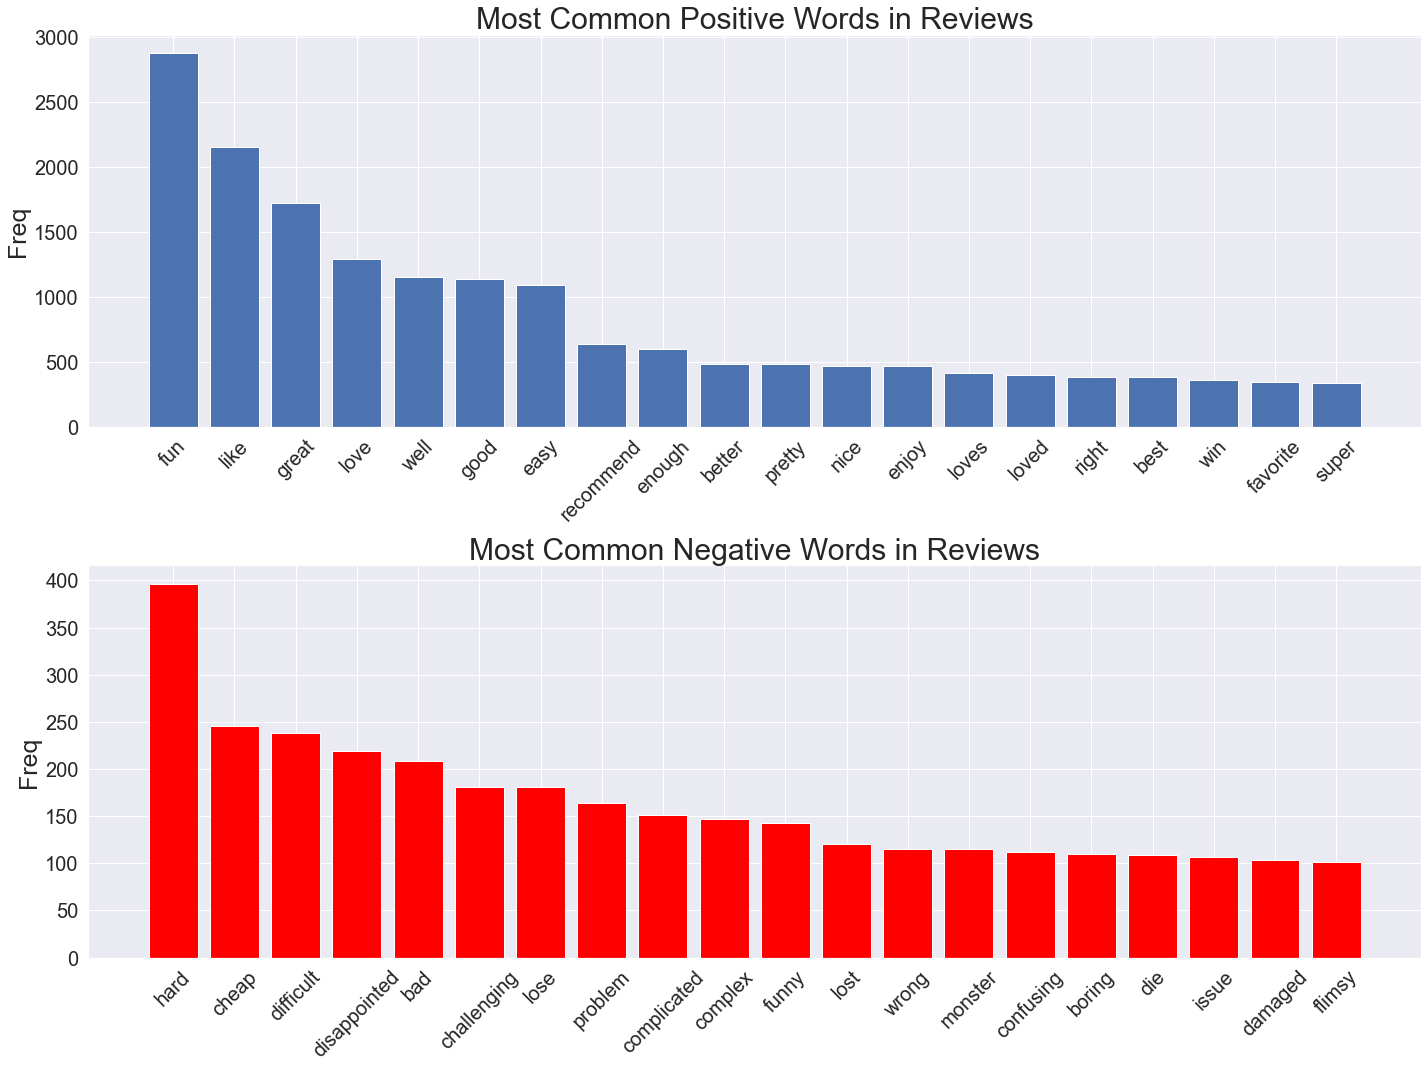

In [58]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,15 ## Sets the height and width of image

fig,ax=plt.subplots(2,1)

top_20_positive_words = dict(list(positive_words.items())[:20])
keys = top_20_positive_words.keys()
values = top_20_positive_words.values()
ax[0].bar(keys, values)
ax[0].set_title('Most Common Positive Words in Reviews',fontsize=30)
# ax[0].set_xlabel('Word',fontsize=25)
ax[0].set_ylabel('Freq',fontsize=25)
ax[0].tick_params(axis='x',labelsize=20,rotation=45)
ax[0].tick_params(axis='y',labelsize=20);

top_20_negative_words = dict(list(negative_words.items())[:20])
keys = top_20_negative_words.keys()
values = top_20_negative_words.values()
ax[1].bar(keys, values,color='red')
# ax[1].bar(keys, values)
ax[1].set_title('Most Common Negative Words in Reviews',fontsize=30)
# ax[1].set_xlabel('Word',fontsize=25)
ax[1].set_ylabel('Freq',fontsize=25)
ax[1].tick_params(axis='x',labelsize=20,rotation=45)
ax[1].tick_params(axis='y',labelsize=20)

fig.tight_layout();

# Count of Reviews for each Item

In [59]:
# number of user_ratings for each board game
table = pd.pivot_table(final_df, index=['asin_id'], columns=['user_rating'],
                       aggfunc='count',
                       fill_value=0.0)['cleaned_reviews']
table['total'] = table[1.0] + table[2.0] + table[3.0] + table[4.0] + table[5.0]
table

user_rating,1.0,2.0,3.0,4.0,5.0,total
asin_id,,,,,,
0786955708,1,2,3,6,18,30
0786958731,0,1,4,2,23,30
0975277324,4,3,2,5,16,30
1223063151,6,4,3,5,12,30
1589935012,0,0,1,0,0,1
...,...,...,...,...,...,...
B08DNN3MZC,0,0,0,0,3,3
B08F65MX4L,0,0,1,0,0,1
B08GD242TJ,0,0,0,1,2,3
